# Laborator 6


In [2]:
import networkx as nx
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import random
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

## Ex. 1.1

In [3]:
G = nx.Graph()

with open("ca-AstroPh.txt", "r") as f:
    for line in f:
        node1, node2 = line.strip().split()
        
        if G.has_edge(node1, node2):
            G[node1][node2]["weight"] += 1
        else:
            G.add_edge(node1, node2, weight=1)

counter = 0

for (u, v, w) in G.edges(data="weight"):
    print(u, v, w)
    counter += 1
    if counter == 10:
        break

84424 276 2
84424 1662 2
84424 5089 2
84424 6058 2
84424 6229 2
84424 10639 2
84424 16442 2
84424 19325 2
84424 19834 2
84424 20113 2


## Ex. 1.2

In [16]:
import networkx as nx
import numpy as np


Ni_dict = {}
Ei_dict = {}
Wi_dict = {}
lambda_dict = {}

for node in G.nodes():
    neighbors = list(G.neighbors(node))
    egonet_nodes = [node] + neighbors
    
    G_egonet = G.subgraph(egonet_nodes)
    
    Ni = len(neighbors)

    Ei = G_egonet.number_of_edges()

    Wi = sum(data["weight"] for _, _, data in G_egonet.edges(data=True))

    A = nx.to_numpy_array(G_egonet, weight="weight")
    eigvals = np.linalg.eigvals(A)
    lambda_wi = max(eigvals)

    Ni_dict[node] = Ni
    Ei_dict[node] = Ei
    Wi_dict[node] = Wi
    lambda_dict[node] = lambda_wi

nx.set_node_attributes(G, Ni_dict,   name="Ni")
nx.set_node_attributes(G, Ei_dict,   name="Ei")
nx.set_node_attributes(G, Wi_dict,   name="Wi")
nx.set_node_attributes(G, lambda_dict, name="lambda_wi")

for node in list(G.nodes())[:10]:
    print(
        f"Node: {node}, "
        f"Ni={G.nodes[node]['Ni']}, "
        f"Ei={G.nodes[node]['Ei']}, "
        f"Wi={G.nodes[node]['Wi']}, "
        f"lambda_wi={G.nodes[node]['lambda_wi']}"
    )

Node: 84424, Ni=75, Ei=286, Wi=571, lambda_wi=25.89489731949176
Node: 276, Ni=31, Ei=86, Wi=171, lambda_wi=16.542559057832193
Node: 1662, Ni=43, Ei=262, Wi=523, lambda_wi=32.478122601953146
Node: 5089, Ni=2, Ei=3, Wi=6, lambda_wi=3.999999999999999
Node: 6058, Ni=90, Ei=1008, Wi=2016, lambda_wi=63.31581539694682
Node: 6229, Ni=42, Ei=149, Wi=298, lambda_wi=(21.265696440162223+0j)
Node: 10639, Ni=118, Ei=941, Wi=1879, lambda_wi=52.67721666334508
Node: 16442, Ni=30, Ei=167, Wi=334, lambda_wi=(26.86390866268919+0j)
Node: 19325, Ni=113, Ei=941, Wi=1882, lambda_wi=48.36279552998625
Node: 19834, Ni=3, Ei=6, Wi=12, lambda_wi=6.0


## Ex. 1.3

In [18]:
import networkx as nx
import numpy as np


nodes = list(G.nodes())
X_vals = []
Y_vals = []
valid_nodes = []

for node in nodes:
    Ni = G.nodes[node].get("Ni", 0)
    Ei = G.nodes[node].get("Ei", 0)

    if Ni > 0 and Ei > 0:
        X_vals.append(np.log(Ni))
        Y_vals.append(np.log(Ei))
        valid_nodes.append(node)

X_vals = np.array(X_vals).reshape(-1, 1)
Y_vals = np.array(Y_vals)

linreg = LinearRegression()
linreg.fit(X_vals, Y_vals)

theta = linreg.coef_[0]
logC  = linreg.intercept_
C = np.exp(logC)

print(f"Fitted parameters: C = {C}, theta = {theta}")

anomaly_scores = {}

for node in nodes:
    Ni = G.nodes[node].get("Ni", 0)
    Ei = G.nodes[node].get("Ei", 0)

    if Ni == 0 or Ei == 0:
        anomaly_scores[node] = 0.0
        continue

    Ei_pred = C * (Ni**theta)

    numerator   = max(Ei, Ei_pred)
    denominator = min(Ei, Ei_pred)

    if denominator == 0:
        anomaly_scores[node] = 0.0
        continue

    ratio = numerator / denominator

    diff_log_term = np.log(abs(Ei - Ei_pred) + 1)

    score_i = ratio * diff_log_term
    anomaly_scores[node] = score_i

nx.set_node_attributes(G, anomaly_scores, "anomaly_score")

for node in list(nodes)[:10]:
    print(f"Node {node}, Ni={G.nodes[node].get('Ni')}, Ei={G.nodes[node].get('Ei')}, "
          f"Anomaly Score={anomaly_scores[node]}")

Fitted parameters: C = 0.9837131129276819, theta = 1.5981048339447423
Node 84424, Ni=75, Ei=286, Anomaly Score=22.309669228425047
Node 276, Ni=31, Ei=86, Anomaly Score=13.906503838973096
Node 1662, Ni=43, Ei=262, Anomaly Score=7.568248741634958
Node 5089, Ni=2, Ei=3, Anomaly Score=0.02177748845697662
Node 6058, Ni=90, Ei=1008, Anomaly Score=7.385984655207181
Node 6229, Ni=42, Ei=149, Anomaly Score=14.19357818830255
Node 10639, Ni=118, Ei=941, Anomaly Score=14.932658956401426
Node 16442, Ni=30, Ei=167, Anomaly Score=5.5250428578346265
Node 19325, Ni=113, Ei=941, Anomaly Score=13.66684371724478
Node 19834, Ni=3, Ei=6, Anomaly Score=0.2819808174138881


## Ex. 1.4

Graph built with 1103 nodes and 1458 edges.
Fitted power law: Ei ~ 1.0485 * (Ni)^1.1719

Top 10 nodes by anomaly score:
Rank 1: Node 126916, Score=11.1049
Rank 2: Node 84424, Score=8.6720
Rank 3: Node 94138, Score=8.6075
Rank 4: Node 106274, Score=8.2481
Rank 5: Node 127393, Score=7.5410
Rank 6: Node 75607, Score=6.9414
Rank 7: Node 13353, Score=6.6276
Rank 8: Node 60471, Score=6.5285
Rank 9: Node 35690, Score=6.3772
Rank 10: Node 30625, Score=5.7151


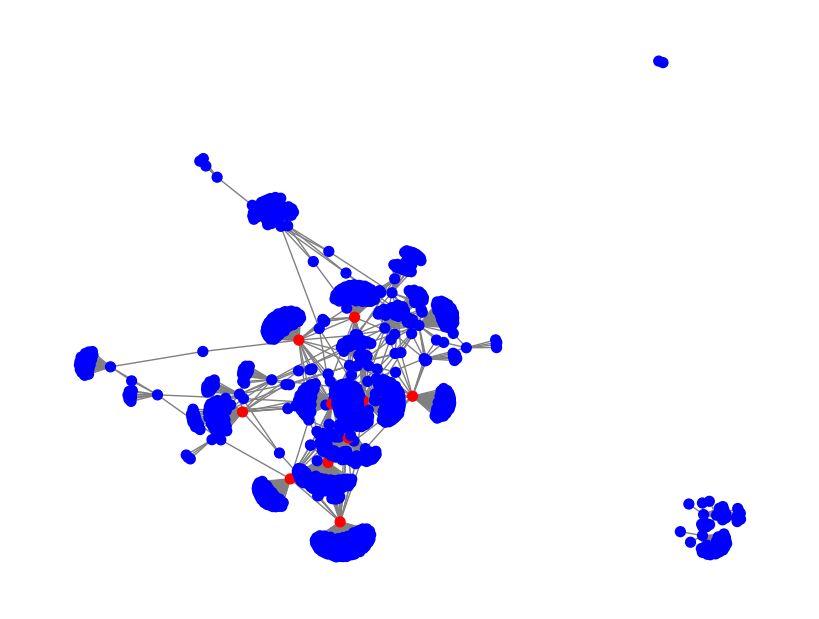

In [21]:
G = nx.Graph()

max_edges = 1500
edge_count = 0

with open("ca-AstroPh.txt", "r") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) != 2 or parts[0].startswith('#'):
            continue
        
        node1, node2 = parts
        if G.has_edge(node1, node2):
            G[node1][node2]["weight"] += 1
        else:
            G.add_edge(node1, node2, weight=1)

        edge_count += 1
        if edge_count >= max_edges:
            break

print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Ni_dict = {}
Ei_dict = {}

for node in G.nodes():
    neighbors = list(G.neighbors(node))
    egonet_nodes = [node] + neighbors
    G_egonet = G.subgraph(egonet_nodes)
    
    Ni = len(neighbors)
    Ei = G_egonet.number_of_edges()
    
    Ni_dict[node] = Ni
    Ei_dict[node] = Ei

nx.set_node_attributes(G, Ni_dict, "Ni")
nx.set_node_attributes(G, Ei_dict, "Ei")

nodes = list(G.nodes())
X_vals = []
Y_vals = []
valid_nodes = []

for node in nodes:
    Ni = G.nodes[node]["Ni"]
    Ei = G.nodes[node]["Ei"]
    
    if Ni > 0 and Ei > 0:
        X_vals.append(np.log(Ni))
        Y_vals.append(np.log(Ei))
        valid_nodes.append(node)

X_vals = np.array(X_vals).reshape(-1, 1)
Y_vals = np.array(Y_vals)

if len(X_vals) == 0:
    print("No valid nodes with Ni>0 and Ei>0. Cannot fit regression.")
else:
    linreg = LinearRegression()
    linreg.fit(X_vals, Y_vals)

    alpha = linreg.intercept_
    beta = linreg.coef_[0]
    C = np.exp(alpha)

    print(f"Fitted power law: Ei ~ {C:.4f} * (Ni)^{beta:.4f}")

    anomaly_scores = {}

    for node in nodes:
        Ni = G.nodes[node]["Ni"]
        Ei = G.nodes[node]["Ei"]
        
        if Ni == 0 or Ei == 0:
            anomaly_scores[node] = 0.0
            continue
        
        Ei_pred = C * (Ni ** beta)
        
        numerator   = max(Ei, Ei_pred)
        denominator = min(Ei, Ei_pred)
        
        if denominator == 0:
            anomaly_scores[node] = 0.0
            continue
        
        ratio = numerator / denominator
        diff_log_term = np.log(abs(Ei - Ei_pred) + 1)
        
        score_i = ratio * diff_log_term
        anomaly_scores[node] = score_i

    nx.set_node_attributes(G, anomaly_scores, "anomaly_score")

    sorted_by_score = sorted(anomaly_scores.items(), key=lambda x: x[1], reverse=True)

    print("\nTop 10 nodes by anomaly score:")
    for i in range(10):
        node_id, score_val = sorted_by_score[i]
        print(f"Rank {i+1}: Node {node_id}, Score={score_val:.4f}")

    top_10_nodes = [node_id for (node_id, _) in sorted_by_score[:10]]

    plt.figure(figsize=(8, 6))

    node_colors = []
    for node in G.nodes():
        if node in top_10_nodes:
            node_colors.append('red')
        else:
            node_colors.append('blue')
    
    pos = nx.spring_layout(G, seed=42)

    nx.draw(
        G, 
        pos,
        with_labels=False,
        node_color=node_colors,
        node_size=50,
        edge_color="gray"
    )
    
    plt.show()

## Ex. 1.5


Top 10 nodes by combined anomaly score:
Rank 1: Node 5412, Combined Score=10000000001.0970
Rank 2: Node 92357, Combined Score=10000000001.0628
Rank 3: Node 21937, Combined Score=1531066018.2746
Rank 4: Node 23579, Combined Score=1531066018.2746
Rank 5: Node 15406, Combined Score=1531066018.2746
Rank 6: Node 33380, Combined Score=1531066018.2746
Rank 7: Node 83560, Combined Score=582842713.6228
Rank 8: Node 96326, Combined Score=6.4227
Rank 9: Node 58532, Combined Score=5.9975
Rank 10: Node 76014, Combined Score=5.9485


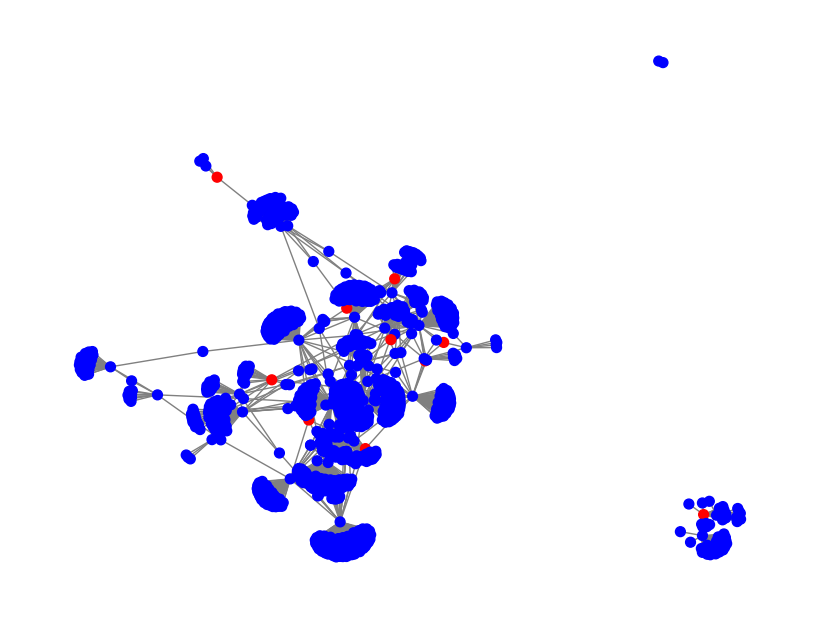

In [24]:
nodes = list(G.nodes())

X = []
valid_nodes = []

for node in nodes:
    Ei = G.nodes[node].get("Ei", 0)
    Ni = G.nodes[node].get("Ni", 0)
    if Ei > 0 and Ni > 0:
        X.append([Ei, Ni])
        valid_nodes.append(node)

X = np.array(X)

lof_model = LocalOutlierFactor(n_neighbors=20, metric='euclidean')
lof_labels = lof_model.fit_predict(X)

lof_scores_raw = -lof_model.negative_outlier_factor_
lof_scores_dict = {}
for node, lof_score in zip(valid_nodes, lof_scores_raw):
    lof_scores_dict[node] = lof_score

for node in nodes:
    if node not in lof_scores_dict:
        lof_scores_dict[node] = 0.0

anomaly_scores = nx.get_node_attributes(G, "anomaly_score")
all_scores = np.array(list(anomaly_scores.values()))
min_score = all_scores.min()
max_score = all_scores.max()
range_score = max_score - min_score if max_score > min_score else 1e-6

normalized_anomaly_scores = {}
for node, score_val in anomaly_scores.items():
    norm_score = (score_val - min_score) / range_score
    normalized_anomaly_scores[node] = norm_score

combined_scores = {}
for node in nodes:
    combined = normalized_anomaly_scores[node] + lof_scores_dict[node]
    combined_scores[node] = combined

nx.set_node_attributes(G, combined_scores, "combined_anomaly_score")

sorted_by_combined = sorted(
    combined_scores.items(), 
    key=lambda x: x[1], 
    reverse=True
)

print("\nTop 10 nodes by combined anomaly score:")
for i in range(10):
    node_id, score_val = sorted_by_combined[i]
    print(f"Rank {i+1}: Node {node_id}, Combined Score={score_val:.4f}")

top_10_nodes = [node_id for (node_id, _) in sorted_by_combined[:10]]

plt.figure(figsize=(8, 6))

node_colors = []
for node in G.nodes():
    if node in top_10_nodes:
        node_colors.append('red')
    else:
        node_colors.append('blue')

pos = nx.spring_layout(G, seed=42)

nx.draw(
    G, 
    pos,
    with_labels=False,
    node_color=node_colors,
    node_size=50,
    edge_color="gray"
)
plt.show()

##  Ex. 2.1

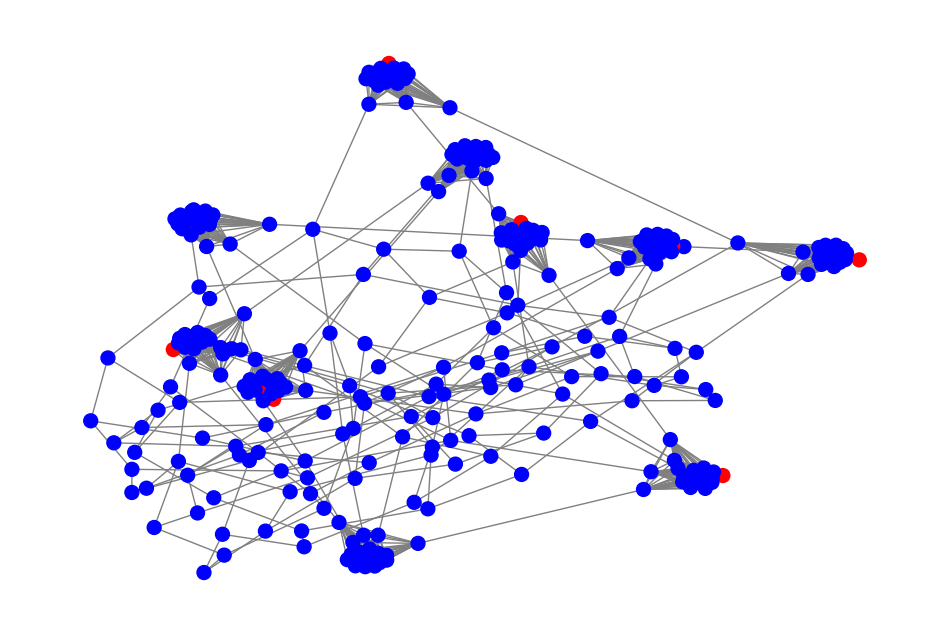

In [26]:
G1 = nx.random_regular_graph(d=3, n=100)

G2 = nx.connected_caveman_graph(l=10, k=20)

G_merged = nx.union(G1, G2, rename=("G1-", "G2-"))

num_random_edges = 30
for _ in range(num_random_edges):
    node_g1 = random.choice(list(G1.nodes()))
    node_g2 = random.choice(list(G2.nodes()))
    G_merged.add_edge(f"G1-{node_g1}", f"G2-{node_g2}")

def cliqueness_score(G, node):
    neighbors = list(G.neighbors(node))
    N_i = len(neighbors)
    if N_i < 2:
        return 0.0
    induced_subgraph = G.subgraph(neighbors)
    E_i = induced_subgraph.number_of_edges()
    max_edges = N_i * (N_i - 1) / 2
    return E_i / max_edges

scores = {n: cliqueness_score(G_merged, n) for n in G_merged.nodes()}

top_10 = sorted(scores, key=scores.get, reverse=True)[:10]

pos = nx.spring_layout(G_merged, seed=42)

node_colors = []
for node in G_merged.nodes():
    if node in top_10:
        node_colors.append('red')
    else:
        node_colors.append('blue')

plt.figure(figsize=(12, 8))
nx.draw_networkx(
    G_merged, 
    pos=pos, 
    node_color=node_colors, 
    with_labels=False,
    node_size=100,
    edge_color='gray'
)
plt.axis("off")
plt.show()


## Ex. 2.2

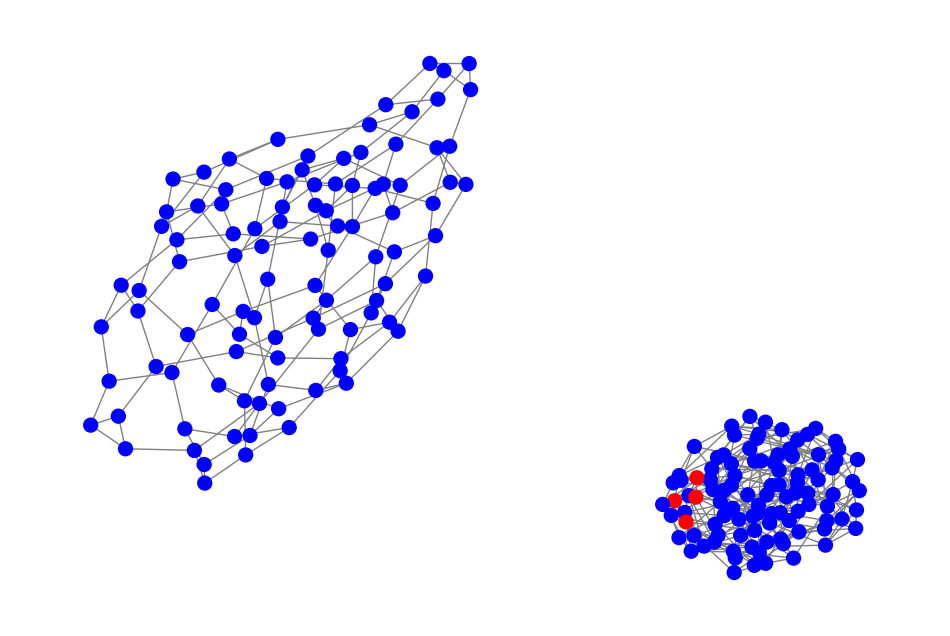

In [27]:
G1 = nx.random_regular_graph(d=3, n=100)
G2 = nx.random_regular_graph(d=5, n=100)

G_merged = nx.union(G1, G2, rename=("G1-", "G2-"))

for u, v in G_merged.edges():
    G_merged[u][v]["weight"] = 1

two_random_nodes = random.sample(list(G_merged.nodes()), 2)

for node in two_random_nodes:
    ego = nx.ego_graph(G_merged, node)
    for u, v in ego.edges():
        G_merged[u][v]["weight"] += 10

def heavy_vicinity_score(G, node):
    neighbors = list(G.neighbors(node))
    
    W_i = sum(G[node][nbr]["weight"] for nbr in neighbors)
    
    induced_subg = G.subgraph(neighbors)
    E_i = sum(data["weight"] for _, _, data in induced_subg.edges(data=True))
    
    return W_i + E_i

scores = {n: heavy_vicinity_score(G_merged, n) for n in G_merged.nodes()}

top_4 = sorted(scores, key=scores.get, reverse=True)[:4]

pos = nx.spring_layout(G_merged, seed=42)

node_colors = []
for n in G_merged.nodes():
    if n in top_4:
        node_colors.append("red")
    else:
        node_colors.append("blue")

plt.figure(figsize=(12, 8))
nx.draw_networkx(
    G_merged,
    pos=pos,
    node_color=node_colors,
    with_labels=False,
    node_size=100,
    edge_color="gray"
)
plt.axis("off")
plt.show()
